### Import libraries

In [37]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from bs4 import BeautifulSoup
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Dense,BatchNormalization
from keras.preprocessing.text import Tokenizer
# nltk.download('stopwords')

### Load Data

In [38]:
data = pd.read_csv('Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [39]:
data.shape

(14640, 15)

In [40]:
data = data.sample(frac=1).reset_index(drop=True) # shuffle data
data = data[data['airline_sentiment']!='neutral'] # remove neutral reviews
print(data.shape)

(11541, 15)


In [41]:
data = data[['airline_sentiment', 'text']] 
data.head()

,airline_sentiment,text
0,negative,@AmericanAir 1416 Cancelled Flightled? Can't g...
1,negative,"@united yes in Lusaka, Zambia. My guess is the..."
3,negative,@USAirways what's happening with 1217 Phl to L...
4,negative,@united ok so what is being done about my expe...
6,negative,@USAirways I have better Intel than she does! ...


<AxesSubplot:>

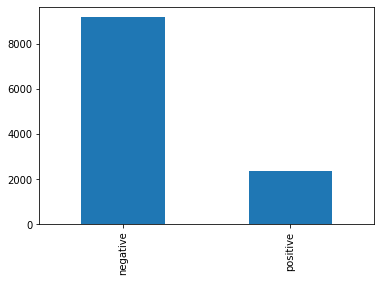

In [45]:
data.airline_sentiment.value_counts().plot.bar()

In [46]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))  
def preprocess(x):
    x = str(x).lower()
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x) # remove email
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x) # remove urls
    x = BeautifulSoup(x, 'lxml').get_text().strip() # remove html tag
    x = re.sub(r'\brt\b', '', x).strip() # remove retweets
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore') # Remove Accented Characters
    x = re.sub(r'[^\w ]+', "", x) # Special Characters 
    x = ' '.join([t for t in x.split() if t not in stop_words]) # Remove Stop words
    x = ' '.join(ps.stem(i) for i in x.split()) # Stemming
    return x

In [47]:
data['text'] = data['text'].apply(lambda x: preprocess(x))

### Tokenization

In [48]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

In [49]:
import pickle
pickle_out = open("tokenizer.pickle","wb")
pickle.dump(tokenizer, pickle_out)
pickle_out.close()

In [50]:
X = tokenizer.texts_to_sequences(data['text'].values)

In [51]:
sent_length=20
padded_sent = pad_sequences(X,padding='pre',maxlen=sent_length)

### Create Model

In [52]:
voc_size = 5000
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(50))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 218,302
Trainable params: 218,302
Non-trainable params: 0
_________________________________________________________________
None


### Compiel model

In [53]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])

### Sperate x and y

In [54]:
import numpy as np
X=np.array(padded_sent)
y=np.array(data['airline_sentiment'].map({'positive':0,"negative":1}))

### Train Test Split

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Train model

In [56]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,)

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32,callbacks=[callbacks])

Epoch 1/20
242/242 [==============================] - 5s 21ms/step - loss: 0.3549 - accuracy: 0.8576 - val_loss: 0.2205 - val_accuracy: 0.9121
Epoch 2/20
242/242 [==============================] - 4s 17ms/step - loss: 0.1680 - accuracy: 0.9351 - val_loss: 0.2083 - val_accuracy: 0.9207
Epoch 3/20
242/242 [==============================] - 4s 18ms/step - loss: 0.1160 - accuracy: 0.9573 - val_loss: 0.2186 - val_accuracy: 0.9186
Epoch 4/20
242/242 [==============================] - 4s 17ms/step - loss: 0.0842 - accuracy: 0.9705 - val_loss: 0.2440 - val_accuracy: 0.9163


### Plot loss

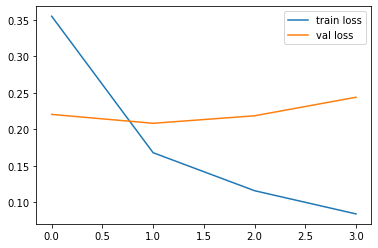

In [57]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

### Plot accuracy

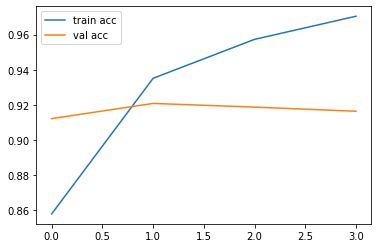

In [58]:
plt.plot(model.history.history['accuracy'], label='train acc')
plt.plot(model.history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

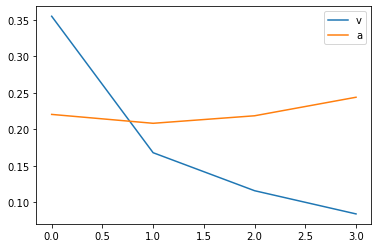

In [59]:
plt.plot(model.history.history['loss'])
plt.legend('train loss')
plt.plot(model.history.history['val_loss'])
plt.legend('val loss')
plt.show()

### Confusion matrix

In [60]:
y_pred = model.prepred = model.predict(X_test)

In [61]:
y_pred = [np.argmax(i) for i in y_pred]

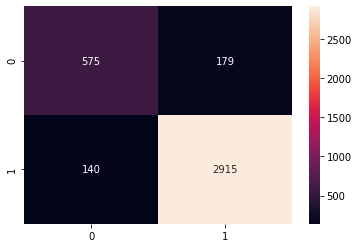

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='.5g')
plt.show()

### Single Review

In [63]:
x = "I hate Movies"
print(x)
x = preprocess(x)
print(x)
x = tokenizer.texts_to_sequences([x])
print(x)
x = pad_sequences(x,maxlen=20,)
print(x)
pred = model.predict(x)
if np.argmax(pred) == 0:
    print("Positive")
else:
    print("Negative")

I hate Movies
hate movi
[[469, 1276]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  469 1276]]
Negative


In [64]:
pred

array([[0.01391802, 0.98608196]], dtype=float32)

In [65]:
x = "I love Movies"
x = preprocess(x)
print(x)
x = tokenizer.texts_to_sequences([x])
print(x)
x = pad_sequences(x,maxlen=20,)
print(x)
pred = model.predict(x)
if np.argmax(pred) == 0:
    print("Positive")
else:
    print("Negative")

love movi
[[85, 1276]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   85 1276]]
Positive


In [66]:
pred

array([[0.7596234 , 0.24037653]], dtype=float32)

### save model

In [67]:
model.save('sent.h5')